In [1]:
import datetime
import time
import json
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
mode = 'bc'
if (mode == 'bc'):
    os.environ['PYSPARK_PYTHON'] = './python3.6.2/bin/python'
    os.environ['HADOOP_USER_NAME'] = 'bigdata_driver_ecosys_test'
    os.environ['HADOOP_USER_PASSWORD'] = '42gdaTh6voXDV0mR2glhNPjWqBxYe22N'
    import findspark
    findspark.init()
    from pyspark import *
    from pyspark.sql import *
    app_name = 'xuyunqing'
    conf = (SparkConf().setAppName(app_name)
            .set('spark.master', 'yarn')
            .set('spark.submit.deployMode', 'client')
            .set('spark.driver.memory',                  '4g')
            .set('spark.executor.memory',                '12g')
            .set('spark.dynamicAllocation.minExecutors', '10')
            .set('spark.driver.maxResultSize' ,           '0')
            .set('spark.dynamicAllocation.maxExecutors', '200')
            .set('spark.yarn.queue',                     'root.kg_novel_dev')
            .set('spark.ui.port','8060')
            .set('spark.yarn.executor.memoryOverhead','3000m')
            .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2 ')
            .set('spark.pyspark.driver.python',          './python3.6.2/bin/python')
            .set('spark.pyspark.python', './python3.6.2/bin/python')
            .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
            )
    spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
    # spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
    sc = spark.sparkContext
from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
from pyspark.sql import functions as F
hc = HiveContext(sc)

In [67]:
import json
import pandas as pd
import requests
from pyspark.sql import HiveContext
from pyspark.sql import SparkSession

webhook = 'https://im-dichat.xiaojukeji.com/api/hooks/incoming/c64821f6-36b7-4a5d-8375-f740ac63b448'

dapan_sql = '''
select
  *
from smt_stg.smt_budget_alloc_dapan_t2
where
  dt = '{dt}'
'''

city_sql = '''
select 
  city_id,
  city_name,
  gmv_type
from smt_stg.smt_mps_city_info
'''

gmv_sql = '''
select
  city_id,
  sum(case when product_id = 110103  then gmv else 0.0 end ) as th_gmv,
  sum(case when product_id = 110101  then gmv else 0.0 end ) as pk_gmv
from mp_data.dm_trip_mp_sd_core_1d
where
  dt = '{dt}'
  and product_id in (110101, 110103)
group by city_id
'''

pred_sql = '''
select
  a.city_id city_id,
  pred_gmv,
  pred_obj_cr,
  pred_pk_gmv,
  pred_th_gmv
from (
select  city_id
        ,sum(if(key_id = 'gmv',estimate_value,0)) as pred_gmv
        ,sum(if(key_id = 'objective_exp_openapi_pp',estimate_value,0)) as pred_obj_cr
from    mp_data.app_trip_mkt_supply_demand_forecast_result_di
where   estimate_date = '{estimate_date}'
        and datediff(estimate_date, dt) = {diff}
        and product_name = '泛快2（快车&特惠快车&市内拼车）'
group by city_id
) a join (
select  city_id
        ,sum(if(product_name = '快车' and key_id = 'gmv',estimate_value,0)) as pred_pk_gmv
        ,sum(if(product_name = '特惠自营' and key_id = 'gmv',estimate_value,0)) as pred_th_gmv
from    mp_data.app_trip_mkt_supply_demand_forecast_result_di
where   estimate_date = '{estimate_date}'
        and datediff(estimate_date, dt) = {diff}
        and product_name in ('快车', '特惠自营')
group by city_id
) b on a.city_id = b.city_id
'''

pred_roi_sql = '''
select
    city_id,
    pred_roi,
    combo_subsidy_rate
from smt_stg.budget_allocation_pred_delta_gmv_v2
where 
    concat_ws('-', year, month, day)='{dt}' 
    and version = 'roi_lgb_v1'
'''
real_roi_sql = '''
select
    exp.city_id as city_id
    ,(exp.avg_gmv - ctl.avg_gmv)/(exp.avg_c - ctl.avg_c) as real_roi
from
    (select
        city_id,
        gmv/group_usr_num as avg_gmv,
        subsidy_c/group_usr_num as avg_c
    from smt_stg.budget_allocation_xfk_city_daily_table
    where group_name='rgroup_joint_exp_pack'
          and product_line = '新泛快'
          and dt = '{dt}'
    ) exp join
    (select
        city_id,
        gmv/group_usr_num as avg_gmv,
        subsidy_c/group_usr_num as avg_c
    from smt_stg.budget_allocation_xfk_city_daily_table
    where group_name='rgroup_joint_blank'
          and product_line = '新泛快'
          and dt = '{dt}'
    ) ctl on exp.city_id = ctl.city_id
'''

exp_hf_sql = '''
select
  a.city as city_id,
  exp_pkhf,
  exp_thhf
from
(select
    dt --日期
    , city --城市
    , JSON_EXTRACT(target_info, '$.rate') as exp_pkhf
from
    ppe.budget_amount_record
where
    dt = '{dt}'
    and amount_type='exp_budget'
    and  tuple_info like '{group}'
    and product_line = 'kuaiche'
    and operator = 'admin'
) a join
(select
    dt --日期
    , city --城市
    , JSON_EXTRACT(target_info, '$.rate') as exp_thhf
from
    ppe.budget_amount_record
where
    dt = '{dt}'
    and amount_type='exp_budget'
    and  tuple_info like '{group}'
    and product_line = 'tehui'
    and operator = 'admin'
) b on a.dt = b.dt and a.city = b.city
'''

insert_sql = '''
insert overwrite table
    smt_stg.smt_err_budget_alloc_sum_t1
partition
    (dt = '{dt}')
select
    source_type,
    err_type,
    city_cnt,
    gmv,
    fkhf_amount,
    mid_cr,
    mid_fkhf,
    city_total,
    gmv_total,
    fkhf_total
from {tmp}
'''

insert_city_sql = '''
insert overwrite table
    smt_stg.smt_err_budget_alloc_city_t1
partition
    (dt = '{dt}')
select
    city_id,
    city_name,
    city_type,
    gmv_type,
    demand,
    source_type,
    err_type,
    gmv,
    exp_cr,
    fkhf,
    pred_gmv,
    target_fkhf,
    obj_cr,
    pred_obj_cr,
    cr_diff,
    fkhf_diff,
    diag1,
    diag2,
    diag3,
    diag4,
    pred_roi,
    real_roi,
    obj_cr_diff,
    pred_obj_cr_diff,
    algo_fkhf,
    algo_fkhf_diff,
    algo_err_type,
    case_level,
    is_manual
from {tmp}
'''


class DChatRobot:
    """DChatRobot"""

    def __init__(self, webhook):
        super(DChatRobot, self).__init__()
        self.webhook = webhook

    def send_message(self, title, content_list, is_md=True):
        data = {
            "text": title,
            "markdown": is_md,
            "attachments": content_list
        }
        return self.post(data)

    def post(self, data):
        post_data = json.dumps({
            "web_hook": self.webhook,
            "data": data
        })
        print(post_data)
        HEADERS = {"Content-Type": "application/json ;charset=utf-8 "}
        req = requests.post("http://10.74.113.54:8021/stg/dchat_notification", post_data,
                            headers=HEADERS)


def get_badcase_by_mean(df, by_category=True, hf_col='', diag_col=''):
    gmv_types = ['']
    if by_category:
        gmv_types = [('特大城市', '大城市', '中城市'), ('小城市', '尾部城市')]
    dfs = []
    for g_type in gmv_types:
        df1 = df[df.gmv_type.isin(g_type)] if by_category else df.copy()
        df1 = df1.reset_index(drop=True)
        m_hf_col = 'm_' + hf_col
        hf_diff_col = hf_col + '_diff'
        df1[m_hf_col] = df1[hf_col].median()
        df1['m_cr'] = df1.exp_cr.median()
        df1[hf_diff_col] = (df1[hf_col] - df1[m_hf_col]) / df1[m_hf_col]
        df1['cr_diff'] = (df1.exp_cr - df1.m_cr) / df1.m_cr
        # add more cr diff
        df1['m_obj_cr'] = df1.obj_cr.median()
        df1['obj_cr_diff'] = (df1.obj_cr - df1.m_obj_cr) / df1.m_obj_cr
        df1['m_pred_obj_cr'] = df1.pred_obj_cr.median()
        df1['pred_obj_cr_diff'] = (df1.pred_obj_cr - df1.m_pred_obj_cr) / df1.m_pred_obj_cr
        df1[diag_col] = '正常'
        for i, row in df1.iterrows():
            dcr, dhf = row.cr_diff, row[hf_diff_col]
            diag = '正常'
            if dcr > 0.03 and dhf < -0.0 and row.real_roi > 1:
                diag = '严重漏补'
            elif dcr > 0.0 and dhf < -0.5 and row.real_roi > 1:
                diag = '中等漏补'
            elif dcr > 0.0 and dhf < -0.05 and row.real_roi > 1:
                diag = '轻度漏补'
            elif dcr < -0.05 and row.fkhf > 0.01:
                diag = '严重误补'
            elif dcr < -0.0 and dhf > 0.5:
                diag = '中等误补'
            elif dcr < -0.0 and dhf > 0.05:
                diag = '轻度误补'
            row[diag_col] = diag
            df1.iloc[i] = row
        dfs.append(df1)
    odf = pd.concat(dfs)
    return odf


def cr_diag(row):
    pred_diff = row.pred_obj_cr - row.obj_cr
    if row.err_type == '正常':
        return row
    elif '误补' in row.err_type:
        if pred_diff > 0.07:
            row.diag1 = 1
        if pred_diff > 0.05:
            row.diag2 = 1
        if pred_diff > 0.03:
            row.diag3 = 1
        if (row.obj_cr < 0.72 and row.pred_obj_cr > 0.72 and pred_diff > 0.03) or (
                row.obj_cr > 0.72 and pred_diff > 0.05):
            row.diag4 = 1
    elif '漏补' in row.err_type:
        if pred_diff < -0.07:
            row.diag1 = 1
        if pred_diff < -0.05:
            row.diag2 = 1
        if pred_diff < -0.03:
            row.diag3 = 1
        if (row.obj_cr > 0.8 and row.pred_obj_cr < 0.8 and pred_diff < -0.04) or (
                row.obj_cr < 0.8 and pred_diff < -0.05):
            row.diag4 = 1
    return row


def get_case_level(row):
    if row.gmv_type == '大城市' and '严重' in row.err_type:
        row.case_level = 'P0'
    elif (row.gmv_type == '大城市' and '中等' in row.err_type) or (
            row.gmv_type == '中城市' and '严重' in row.err_type):
        row.case_level = 'P1'
    elif '正常' in row.err_type:
        row.case_level = '/'
    else:
        row.case_level = 'P2'
    return row


def main(day,exp_df):
    # spark = SparkSession.builder.appName(
    #     'pukuai_tehui_zhuanche_dgmv_pred daily inference').enableHiveSupport().getOrCreate()
    # spark.conf.set('spark.sql.broadcastTimeout', 360000)
    # spark.conf.set('hive.exec.dynamic.partition.mode', 'nonstrict')
    # spark.sql('set spark.sql.hive.convertMetastoreOrc=true')
    # spark.sql('set spark.sql.orc.impl=native')
    # spark.sql('set dfs.client.socket-timeout=600000')
    # sc = spark.sparkContext
    # hc = HiveContext(sc)

    # yesterday = '${BIZ_DATE_LINE}'
    yesterday = day
    df = hc.sql(dapan_sql.format(dt=yesterday)).toPandas()
    city_df = hc.sql(city_sql).toPandas()
    df = pd.merge(df, city_df, on='city_id', how='left')
    df = df[df.city_type == '非战区非下沉']
    for i in range(1, 3):
        pred_df = hc.sql(pred_sql.format(estimate_date=yesterday, diff=i)).toPandas()
        if not pred_df.empty:
            break
    df = pd.merge(df, pred_df, how='left', on='city_id')
    gmv_df = hc.sql(gmv_sql.format(dt=yesterday)).toPandas()
    df = pd.merge(df, gmv_df, how='left', on='city_id')
    df = df.fillna('0').astype({
        'gmv': 'float',
        'exp_cr': 'float',
        'intelligent_subsidy_c': 'float',
        'real_thhf': 'float',
        'real_pkhf': 'float',
        'algo_thhf': 'float',
        'algo_pkhf': 'float',
        'obj_cr': 'float',
        'pred_obj_cr': 'float',
        'pred_pk_gmv': 'float',
        'pred_th_gmv': 'float',
        'pred_gmv': 'float',
        'pk_gmv': 'float',
        'th_gmv': 'float',
    })
    real_roi_df = hc.sql(real_roi_sql.format(dt=yesterday)).toPandas()
    df = pd.merge(df, real_roi_df, how='left', on='city_id')
    df['real_roi'] = df.real_roi.fillna(0)
    df['fkhf'] = df.intelligent_subsidy_c / df.gmv

    df['target_fkhf'] = (df.pred_pk_gmv * df.real_pkhf + df.pred_th_gmv * df.real_thhf) / df.pred_gmv
    df['algo_fkhf'] = (df.pred_pk_gmv * df.algo_pkhf + df.pred_th_gmv * df.algo_thhf) / df.pred_gmv
    # 判断 bad case
    df = get_badcase_by_mean(df, True, 'algo_fkhf', 'algo_err_type')
    df = get_badcase_by_mean(df, True, 'fkhf', 'err_type')

    df = pd.merge(df, exp_df, how='left', on='city_id')
    for col in ['MPS2','ZJB','MPS15','NN1','NN2','NN2ECR','NN2DCR']:
        df = get_badcase_by_mean(df, True, col+'_exp_fkhf', col+'_err_type')
    
    return df,exp_df

In [68]:
mps_exp2_df_1 = pd.read_csv('../mps_exp_2/mps_2_exp_result.csv')[['city_id','dt','exp_fkhf']].rename(columns = {'exp_fkhf':'MPS2_exp_fkhf'})
mps_exp2_df_2 = pd.read_csv('multi_funnel_same_dsend_two_stage_result_0522_0528.csv')[['city_id','dt','exp_fkhf']].rename(columns = {'exp_fkhf':'ZJB_exp_fkhf'})
mps_exp2_df_3 = pd.read_csv('abtest_1.5_result_0522_0528.csv')[['city_id','dt','exp_fkhf']].rename(columns = {'exp_fkhf':'MPS15_exp_fkhf'})
mps_exp2_df_4 = pd.read_csv('nn1.csv').rename(columns = {'stat_date':'dt','crate':'exp_fkhf'})[['city_id','dt','exp_fkhf']].rename(columns = {'exp_fkhf':'NN1_exp_fkhf'})
mps_exp2_df_5 = pd.read_csv('nn2.csv').rename(columns = {'stat_date':'dt','crate':'exp_fkhf'})[['city_id','dt','exp_fkhf']].rename(columns = {'exp_fkhf':'NN2_exp_fkhf'})
mps_exp2_df_6 = pd.read_csv('nn2_without_ecr.csv').rename(columns = {'stat_date':'dt','crate':'NN2ECR_exp_fkhf'})[['city_id','dt','NN2ECR_exp_fkhf']]
mps_exp2_df_7 = pd.read_csv('nn2_d_cr.csv').rename(columns = {'stat_date':'dt','crate':'NN2DCR_exp_fkhf'})[['city_id','dt','NN2DCR_exp_fkhf']]

mps_df = pd.merge(mps_exp2_df_1,mps_exp2_df_2,on = ['city_id','dt'],how = 'left')
mps_df = pd.merge(mps_df,mps_exp2_df_3,on = ['city_id','dt'],how = 'left')
mps_df = pd.merge(mps_df,mps_exp2_df_4,on = ['city_id','dt'],how = 'left')
mps_df = pd.merge(mps_df,mps_exp2_df_5,on = ['city_id','dt'],how = 'left')
mps_df = pd.merge(mps_df,mps_exp2_df_6,on = ['city_id','dt'],how = 'left')
mps_df = pd.merge(mps_df,mps_exp2_df_7,on = ['city_id','dt'],how = 'left')

In [69]:
dfs = []
df_list = []
start_date = '2023-05-22'
end_date = '2023-05-28'
date_list = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m-%d').tolist()
print(date_list)

for day in date_list:
    df,exp_df = main(day,mps_df.query('dt == "%s"'%day))
    df_list.append(df)
df_total = pd.concat(df_list)


['2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25', '2023-05-26', '2023-05-27', '2023-05-28']


In [74]:
df_total.query('city_id not in (1,13,16) and gmv_type in ("大城市","中城市","特大城市") and NN2DCR_err_type == "严重误补"')[['city_name','dt_x','obj_cr','exp_cr','algo_fkhf','MPS2_exp_fkhf','ZJB_exp_fkhf','MPS15_exp_fkhf','NN1_exp_fkhf','NN2_exp_fkhf','NN2ECR_exp_fkhf','NN2DCR_exp_fkhf']]

,city_name,dt_x,obj_cr,exp_cr,algo_fkhf,MPS2_exp_fkhf,ZJB_exp_fkhf,MPS15_exp_fkhf,NN1_exp_fkhf,NN2_exp_fkhf,NN2ECR_exp_fkhf,NN2DCR_exp_fkhf
11,常州市,2023-05-22,0.712372,0.865043,0.047460,0.036525,0.036090,0.054994,0.050708,0.050708,0.042964,0.050894
16,沈阳市,2023-05-25,0.734196,0.888038,0.006637,0.032216,0.011863,0.032353,0.009706,0.009706,0.009706,0.021569
9,郑州市,2023-05-26,0.716378,0.862042,0.060696,0.064498,0.081422,0.070266,0.065202,0.065202,0.035422,0.037506
13,沈阳市,2023-05-26,0.690383,0.867280,0.006707,0.004833,0.000896,0.013435,0.009853,0.009853,0.009853,0.022999
29,合肥市,2023-05-26,0.683409,0.848048,0.060415,0.065464,0.053655,0.070692,0.054567,0.054567,0.050201,0.054925
8,沈阳市,2023-05-27,0.667742,0.863883,0.006894,0.008097,0.000876,0.024055,0.009638,0.009638,0.009638,0.021665
12,石家庄市,2023-05-27,0.681442,0.833856,0.017975,0.040911,0.011556,0.024016,0.019863,0.019863,0.019863,0.021247
27,汕头市,2023-05-27,0.747959,0.864349,0.026955,0.025677,0.033228,0.004639,0.034016,0.034016,0.048234,0.042838
18,沈阳市,2023-05-28,0.657345,0.862274,0.006916,0.011063,0.000804,0.028933,0.009644,0.009644,0.009644,0.026366
24,南昌市,2023-05-28,0.716248,0.868951,0.040923,0.091115,0.001922,0.038917,0.083547,0.083547,0.064790,0.053255


In [76]:
df_total.query('city_id not in (1,13,16) and gmv_type in ("大城市","中城市","特大城市") and NN2DCR_err_type == "中等漏补"')[['city_name','dt_x','obj_cr','exp_cr','algo_fkhf','MPS2_exp_fkhf','ZJB_exp_fkhf','MPS15_exp_fkhf','NN1_exp_fkhf','NN2_exp_fkhf','NN2ECR_exp_fkhf','NN2DCR_exp_fkhf']]

,city_name,dt_x,obj_cr,exp_cr,algo_fkhf,MPS2_exp_fkhf,ZJB_exp_fkhf,MPS15_exp_fkhf,NN1_exp_fkhf,NN2_exp_fkhf,NN2ECR_exp_fkhf,NN2DCR_exp_fkhf
0,东莞市,2023-05-22,0.843016,0.940065,0.030678,0.031201,0.043163,0.034421,0.033606,0.032609,0.038044,0.019928
6,江门市,2023-05-22,0.877968,0.946432,0.022944,0.027168,0.001942,0.023232,0.033482,0.033015,0.034957,0.019420
3,中山市,2023-05-24,0.856708,0.939038,0.026986,0.022876,0.007935,0.027199,0.036605,0.036605,0.036605,0.021532
33,肇庆市,2023-05-25,0.882909,0.945237,0.024907,0.024609,0.006938,0.025343,0.035215,0.034013,0.047618,0.020408
6,金华市,2023-05-26,0.811616,0.923981,0.020048,0.022098,0.039002,0.023401,0.031202,0.031202,0.049403,0.020801
32,中山市,2023-05-26,0.846340,0.937452,0.015999,0.017295,0.002113,0.022806,0.032588,0.032588,0.033810,0.021131


In [70]:
 for col in ['algo','MPS2','ZJB','MPS15','NN1','NN2','NN2ECR','NN2DCR']:
        print(df_total.query('city_id not in (1,13,16) and gmv_type in ("大城市","中城市","特大城市")').groupby(col+'_err_type').agg({'city_id':'count'}))

               city_id
algo_err_type         
严重漏补                 1
严重误补                10
中等误补                26
正常                 161
轻度漏补                22
轻度误补                18
               city_id
MPS2_err_type         
严重漏补                 1
严重误补                10
中等漏补                 2
中等误补                23
正常                 153
轻度漏补                24
轻度误补                25
              city_id
ZJB_err_type         
严重漏补                1
严重误补               10
中等漏补               19
中等误补               15
正常                158
轻度漏补               11
轻度误补               24
                city_id
MPS15_err_type         
严重误补                 10
中等漏补                  1
中等误补                 22
正常                  172
轻度漏补                 22
轻度误补                 11
              city_id
NN1_err_type         
严重误补               10
中等误补               24
正常                179
轻度漏补               15
轻度误补               10
              city_id
NN2_err_type         
严重误补               10

In [118]:
columns = 'NN2DCR_exp_fkhf'
columns2 = 'NN2DCR_err_type'
df_total.query('city_id not in (1, 13, 16) and gmv_type in ("大城市", "中城市", "特大城市") and algo_fkhf - %s > 0.02 '%columns)[['city_name','algo_fkhf',columns,'algo_err_type',columns2,'obj_cr','exp_cr']].groupby(['city_name']).agg({'exp_cr':'count','algo_err_type':list,columns2:list}).reset_index().rename(columns = {'exp_cr':'nums'}).sort_values(['nums'],ascending = False)

,city_name,nums,algo_err_type,NN2DCR_err_type
1,南昌市,4,"[中等误补, 中等误补, 中等误补, 中等误补]","[正常, 轻度误补, 轻度误补, 正常]"
3,徐州市,4,"[中等误补, 中等误补, 中等误补, 中等误补]","[正常, 正常, 正常, 正常]"
6,贵阳市,4,"[中等误补, 中等误补, 中等误补, 中等误补]","[正常, 正常, 正常, 轻度误补]"
0,南宁市,2,"[正常, 正常]","[正常, 正常]"
2,厦门市,2,"[正常, 正常]","[轻度漏补, 正常]"
5,福州市,2,"[正常, 正常]","[正常, 正常]"
7,郑州市,2,"[严重误补, 中等误补]","[严重误补, 正常]"
4,无锡市,1,[正常],[轻度漏补]


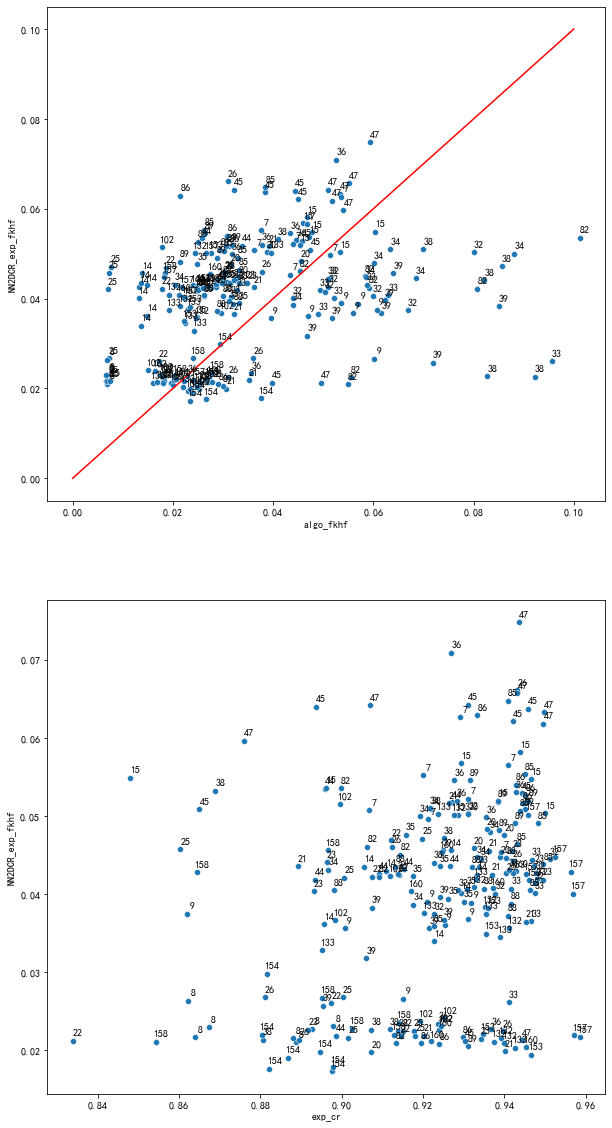

In [85]:
fig, axis = plt.subplots(2,1, figsize = (10, 20))
sns.scatterplot(data=df_total.query('city_id not in (1,13,16) and gmv_type in ("大城市","中城市","特大城市")'), x='algo_fkhf', y='NN2DCR_exp_fkhf', ax=axis[0])
axis[0].plot([0,0.1],[0,0.1],c = 'r')
# 添加城市ID标签
for index, row in df_total.query('city_id not in (1,13,16) and gmv_type in ("大城市","中城市","特大城市")').iterrows():
   axis[0].annotate(row['city_id'], (row['algo_fkhf'], row['NN2DCR_exp_fkhf']), textcoords="offset points", xytext=(5, 5), ha='center')
# axis[0].set_xlabel('线上核销c补roi')
# axis[0].set_ylabel('模拟分配补贴率 - 线上补贴率')

sns.scatterplot(data=df_total.query('city_id not in (1,13,16) and gmv_type in ("大城市","中城市","特大城市")'), x='exp_cr', y='NN2DCR_exp_fkhf', ax=axis[1])
# 添加城市ID标签
for index, row in df_total.query('city_id not in (1,13,16) and gmv_type in ("大城市","中城市","特大城市")').iterrows():
   axis[1].annotate(row['city_id'], (row['exp_cr'], row['NN2DCR_exp_fkhf']), textcoords="offset points", xytext=(5, 5), ha='center')